# #2文本分类

In [1]:
import numpy as np
import torch
import torch.nn as nn
from tqdm import tqdm
import pickle
from torch.autograd import Variable
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset,DataLoader,TensorDataset

In [180]:
with open("source/glove/glove.6B.100d.txt", 'r') as f:
    embedding_matrix = f.readlines()

In [54]:
index2word = {}
word2index = {}
new_embedding_matrix = []
for idx, embed_item in enumerate(tqdm(embedding_matrix)):
    cur_words = embed_item.strip().split(" ")
    word = cur_words[0]
    weight = [float(value) for value in cur_words[1:]]
    index2word[idx] = word
    word2index[word] = idx
    new_embedding_matrix.append(weight)
with open("source/glove/glove.6B.100d.pkl", 'wb') as f:
    pickle.dump(new_embedding_matrix,f)
with open("source/glove/idx2word_word2idx", 'wb') as f:
    pickle.dump((index2word,word2index),f)

100%|██████████| 400000/400000 [00:19<00:00, 20402.24it/s]


In [55]:
word2index['pad']

10109

In [57]:
index2word[10109]

'pad'

In [51]:
print(len(index2word), len(word2index))

400000 400000


In [58]:
# 不需要扩展pad
# index2word[400000] = 'pad'
# word2index['pad'] = 400000
# new_embedding_matrix = np.vstack((new_embedding_matrix,np.ones((1,100))))
with open("source/glove/glove.6B.100d.pkl2", 'wb') as f:
    pickle.dump(np.array(new_embedding_matrix),f)
# with open("source/glove/idx2word_word2idx.pkl2", 'wb') as f:
#     pickle.dump((index2word,word2index),f)

In [2]:
with open("source/glove/glove.6B.100d.pkl2", 'rb') as f:
    new_embedding_matrix = pickle.load(f)
#new_embedding_matrix = np.array(new_embedding_matrix)
with open("source/glove/idx2word_word2idx", 'rb') as f:
    index2word, word2index = pickle.load(f)

In [3]:
# 读取数据集
with open("dataset.pkl","rb") as f:
    train_data,train_label = pickle.load(f)
with open("testset.pkl","rb") as f:
    test_data = pickle.load(f)

In [46]:
import matplotlib.pyplot as plt
%matplotlib inline

In [60]:
# data word length
from collections import Counter
def countNumOfDataset(dataset):
    counter = Counter()
    for item in dataset:
        words = item.strip().split(" ")
        counter.update([len(words)])
    counter_list = counter.most_common()
    x_list = []
    y_list = []
    for x, y in counter_list:
        x_list.append(x)
        y_list.append(y)
    return counter_list,x_list,y_list
co,x_l,y_l = countNumOfDataset(train_data)

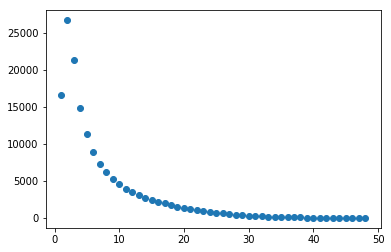

In [63]:
# distribution
plt.scatter(x_l,y_l)

In [4]:
# 根据数据分布选择20个词作为截断，构建数据集合
def convert2gloveindex(dataset,dataset_label, word2index, limit=20):
    new_dataset = []
    new_datalabel = []
    for item,label in zip(dataset,dataset_label):
        words = item.strip().split(" ")
        if len(words) <= 1 and words[0] == '':
            continue
        # find word in glove, for unk we get a default index
        cur_indexs = [word2index.setdefault(word,201534) for word in words[:limit]]
        if len(cur_indexs) <= limit:
            cur_indexs = cur_indexs + [word2index['pad']]*(limit - len(cur_indexs))
        new_dataset.append(cur_indexs)
        new_datalabel.append(label)
    return new_dataset, new_datalabel

train_data2,train_label2 = convert2gloveindex(train_data,train_label,word2index, 20)
#test_data2,train_label2 = convert2gloveindex(test_data,train_label,word2index, 20)

In [5]:
train_data3 = np.array(train_data2)
train_label3 = np.array(train_label2)
# new_train_label = np.zeros((train_label3.shape[0],5))
# for idx,item in enumerate(train_label3):
#     new_train_label[idx][item[0]] = 1

In [6]:
train_x,test_x,train_y,test_y = train_test_split(train_data3,train_label3, test_size = 0.2, random_state=42)

In [7]:
train_x = torch.from_numpy(train_x)
train_y = torch.from_numpy(train_y)
test_x = torch.from_numpy(test_x)
test_y = torch.from_numpy(test_y)

In [8]:
# create dataload
deal_dataset = TensorDataset(train_x,train_y)
train_dataloader = DataLoader(deal_dataset,batch_size=200,shuffle=True,num_workers=2)
deal_dataset2 = TensorDataset(test_x,test_y)
test_dataloader = DataLoader(deal_dataset2,batch_size=100,shuffle=True,num_workers=2)

In [9]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [10]:
new_embedding_matrix = torch.Tensor(new_embedding_matrix)

In [300]:
class textCNN(nn.Module):
    
    def __init__(self, args):
        super(textCNN, self).__init__()
        self.vocab_size = args['vocab_size']
        self.vocab_dim = args['vocab_dim']
        self.n_class = args['n_class']
        self.max_len = args['max_len']
        self.emb_matrix = args['emb_matrix']
        self.window_size = args['window_size']
        # model block
        # _weight:默认embedding矩阵，这里是glove
        self.embedding = nn.Embedding(self.vocab_size, self.vocab_dim, _weight=self.emb_matrix)
        self.conv1 = nn.Sequential(
                        nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(self.window_size,self.vocab_dim),
                                  stride=1, padding=(0,0)),
                        nn.ReLU(),
                    )
        self.output = nn.Linear(16*18*1,self.n_class)
    
    def forward(self, x):
        x = self.embedding(x)
        # convert to [batch,1,word,100]
        x = x.view(x.size(0), 1, self.max_len, 100)
        #print(x.size())
        x = self.conv1(x)
        # convert to [batch,16]
        #print(x.size())
        x = x.view(x.size(0),-1)
        output = self.output(x)
        return output
        
        

In [301]:
args = {}
args['vocab_size'] = len(index2word)
args['max_len'] = 20
args['n_class'] = 5
args['vocab_dim'] = 100
args['emb_matrix'] = new_embedding_matrix
args['window_size'] = 3
epoch = 20

model = textCNN(args).cuda()
lr = 0.001
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=lr)

In [304]:
total_step = len(train_dataloader)
for epo in range(epoch):
    for i, (batch_x,batch_y) in enumerate(train_dataloader):
        batch_x = batch_x.cuda().to(device)
        batch_y = batch_y.cuda().to(device,)
        # forward
        output = model(batch_x)
        #print(output)
        #print(output)
        #print(batch_y.float())
        loss = criterion(output, batch_y.long())
        
        # backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if(i+1) % 100 == 0:
            _, predicted = torch.max(output.data, 1)
            correct = (predicted==batch_y).sum().item()
            score = float('%.4f' %(correct / batch_y.size(0)))
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, score:{:.4f}' 
                   .format(epo+1, epoch, i+1, total_step, loss.item(), score))
        

Epoch [1/20], Step [100/624], Loss: 0.6058, score:0.7600
Epoch [1/20], Step [200/624], Loss: 0.5281, score:0.7850
Epoch [1/20], Step [300/624], Loss: 0.5712, score:0.7800
Epoch [1/20], Step [400/624], Loss: 0.6318, score:0.7600
Epoch [1/20], Step [500/624], Loss: 0.6943, score:0.7450
Epoch [1/20], Step [600/624], Loss: 0.6493, score:0.7500
Epoch [2/20], Step [100/624], Loss: 0.5035, score:0.7850
Epoch [2/20], Step [200/624], Loss: 0.6079, score:0.7650
Epoch [2/20], Step [300/624], Loss: 0.6222, score:0.7500
Epoch [2/20], Step [400/624], Loss: 0.4722, score:0.8300
Epoch [2/20], Step [500/624], Loss: 0.6202, score:0.7350
Epoch [2/20], Step [600/624], Loss: 0.6163, score:0.7650
Epoch [3/20], Step [100/624], Loss: 0.4781, score:0.7900
Epoch [3/20], Step [200/624], Loss: 0.5127, score:0.8150
Epoch [3/20], Step [300/624], Loss: 0.7002, score:0.6900
Epoch [3/20], Step [400/624], Loss: 0.6359, score:0.7500
Epoch [3/20], Step [500/624], Loss: 0.6556, score:0.7300
Epoch [3/20], Step [600/624], L

In [309]:
# Test the model
model.eval()  # eval mode (batchnorm uses moving mean/variance instead of mini-batch mean/variance)
with torch.no_grad():
    correct = 0
    total = 0
    for i, (batch_x,batch_y) in enumerate(test_dataloader):
        batch_x = batch_x.cuda().to(device)
        batch_y = batch_y.cuda().to(device,)
        # forward
        output = model(batch_x)
        _, predicted = torch.max(output.data, 1)
        total += batch_y.size(0)
        correct += (predicted == batch_y).sum().item()

    print('Test Accuracy of the model on the test data: {}%'.format(100 * float('%.4f' %(correct / total))))

Test Accuracy of the model on the test data: 62.18%


In [11]:
class textRNN(nn.Module):
    
    def __init__(self, args):
        super(textRNN, self).__init__()
        self.vocab_size = args['vocab_size']
        self.vocab_dim = args['vocab_dim']
        self.input_size = args['input_size']
        self.hidden_size = args['hidden_size']
        self.num_layers = args['num_layers']
        
        self.emb_matrix = args['emb_matrix']
        self.max_len = args['max_len']
        self.n_class = args['n_class']
        self.embedding = nn.Embedding(self.vocab_size, self.vocab_dim, _weight=self.emb_matrix)
        self.lstm = nn.LSTM(self.input_size, self.hidden_size, self.num_layers, batch_first=True)
        self.fc = nn.Linear(self.hidden_size, self.n_class)
        
    def forward(self, x):
        # [batchsize,word] -> [batchsize,word,100]
        x = self.embedding(x)
        # 给cell中的h和c（state）设置初始状态
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        
        # 计算LSTM的正向传播
        out, _ = self.lstm(x,(h0,c0))  # output: tensor of shape (b, seq_len, hidden_size)
        
        # 取得out中的最后一个cell的state作为结果
        output = self.fc(out[:,-1,:])
        return output
    

In [12]:
args2 = {}
args2['vocab_size'] = len(index2word)
args2['vocab_dim'] = 100
args2['input_size'] = 100
args2['hidden_size'] = 128
args2['num_layers'] = 2

args2['emb_matrix'] = new_embedding_matrix
args2['max_len'] = 20
args2['n_class'] = 5

epoch = 20

model2 = textRNN(args2).cuda()
lr = 0.01
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model2.parameters(),lr=lr)

In [13]:
total_step = len(train_dataloader)
for epo in range(epoch):
    for i, (batch_x,batch_y) in enumerate(train_dataloader):
        batch_x = batch_x.cuda().to(device)
        batch_y = batch_y.cuda().to(device,)
        # forward
        output = model2(batch_x)
        #print(output)
        #print(output)
        #print(batch_y.float())
        loss = criterion(output, batch_y.long())
        
        # backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if(i+1) % 100 == 0:
            _, predicted = torch.max(output.data, 1)
            correct = (predicted==batch_y).sum().item()
            score = float('%.4f' %(correct / batch_y.size(0)))
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, score:{:.4f}' 
                   .format(epo+1, epoch, i+1, total_step, loss.item(), score))
        

Epoch [1/20], Step [100/624], Loss: 1.1828, score:0.5550
Epoch [1/20], Step [200/624], Loss: 1.0103, score:0.5950
Epoch [1/20], Step [300/624], Loss: 0.8879, score:0.6200
Epoch [1/20], Step [400/624], Loss: 0.8669, score:0.6250
Epoch [1/20], Step [500/624], Loss: 0.7584, score:0.6750
Epoch [1/20], Step [600/624], Loss: 0.9178, score:0.6100
Epoch [2/20], Step [100/624], Loss: 0.7837, score:0.6750
Epoch [2/20], Step [200/624], Loss: 0.8016, score:0.6700
Epoch [2/20], Step [300/624], Loss: 0.9366, score:0.5900
Epoch [2/20], Step [400/624], Loss: 0.7226, score:0.7100
Epoch [2/20], Step [500/624], Loss: 0.7874, score:0.6700
Epoch [2/20], Step [600/624], Loss: 0.8552, score:0.6600
Epoch [3/20], Step [100/624], Loss: 0.6423, score:0.7100
Epoch [3/20], Step [200/624], Loss: 0.8199, score:0.6500
Epoch [3/20], Step [300/624], Loss: 0.7236, score:0.7100
Epoch [3/20], Step [400/624], Loss: 0.7242, score:0.7100
Epoch [3/20], Step [500/624], Loss: 0.6651, score:0.7250
Epoch [3/20], Step [600/624], L

In [15]:
# Test the model
model2.eval()  # eval mode (batchnorm uses moving mean/variance instead of mini-batch mean/variance)
with torch.no_grad():
    correct = 0
    total = 0
    for i, (batch_x,batch_y) in enumerate(test_dataloader):
        batch_x = batch_x.cuda().to(device)
        batch_y = batch_y.cuda().to(device,)
        # forward
        output = model2(batch_x)
        _, predicted = torch.max(output.data, 1)
        total += batch_y.size(0)
        correct += (predicted == batch_y).sum().item()

    print('Test Accuracy of the model on the test data: {}%'.format(100 * float('%.4f' %(correct / total))))
torch.save(model2.state_dict(),'modelRNN.ckpt')

Test Accuracy of the model on the test data: 65.19%


In [16]:
model2

textRNN(
  (embedding): Embedding(400000, 100)
  (lstm): LSTM(100, 128, num_layers=2, batch_first=True)
  (fc): Linear(in_features=128, out_features=5, bias=True)
)